# Model Training: Forwards - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [58]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [59]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_final.csv'
data = pd.read_csv(filepath)

## Features to try:

Recall that the EDA done revealed that we should try to use the following features:

1. TOI/GP
2. XGF/60 - and possibly combining it with SCF/60, FF/60, HDCF/60, CF/60, SF/60, and MDCF/60 to create a new feature.
3. GF/60
4. TOTAL ASSISTS/60 - But possibly using FIRST ASSISTS/60 and SECOND_ASSISTS/60 instead.
5. GOALS/60
6. Handedness

In [61]:
forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 41 or more games played
forwards_41GP = forwards[(forwards['GP'] >= 41)].copy()
test_train_data = forwards_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0004611236956475344


In [62]:
# Assuming your pipeline is named 'pipeline' and has been fitted

# Step 2 & 3: Access the trained XGBRegressor model and get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
features = numerical_features  # This should be the list of features used to train the model

# Step 4: Map feature importances to feature names
importance_dict = dict(zip(features, feature_importances))

# Sort the features by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# # Print the sorted feature importances
# for feature, importance in sorted_importances:
#     print(f"{feature}: {importance}")

# If you have a large number of features and only want to see the top ones, you can slice the list
print("Top 10 most important features:")
for feature, importance in sorted_importances[:10]:
    print(f"{feature}: {importance}")


Top 10 most important features:
OFF. ZONE FACEOFFS/GP: 0.16857989132404327
CF/GP: 0.16071449220180511
TOI/GP: 0.06594657152891159
LDCF/GP: 0.024764515459537506
SCF/GP: 0.022304141893982887
XGF/GP: 0.018174340948462486
SHOTS/GP: 0.016641877591609955
HITS TAKEN/60: 0.014070931822061539
FF/GP: 0.013306817971169949
GIVEAWAYS/GP: 0.010946204885840416


In [63]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [64]:
# Create a feature column in Centers for the predicted salary
forwards['PRED_SALARY_PERCENTAGE'] = pipeline.predict(forwards)

# Create a column for the actual predicted salary
forwards['PRED_AAV'] = forwards['PRED_SALARY_PERCENTAGE'] * forwards['SALARY CAP']
forwards['PRED_AAV'] = forwards['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
forwards['DIFF'] = forwards['PRED_AAV'] - forwards['AAV']

# Convert to dollars
forwards['PRED_AAV'] = convert_to_dollars(forwards, 'PRED_AAV')
forwards['AAV'] = convert_to_dollars(forwards, 'AAV')
forwards['DIFF'] = convert_to_dollars(forwards, 'DIFF')

In [65]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = forwards.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON'] + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
334,alex ovechkin,2008-09,"$9,538,462.00","$9,267,152.00","$-271,310.00",0.163442
335,alex ovechkin,2009-10,"$9,538,462.00","$9,262,833.00","$-275,629.00",0.163078
2923,connor mcdavid,2021-22,"$12,500,000.00","$12,297,966.00","$-202,034.00",0.150895
1395,brad richards,2007-08,"$7,800,000.00","$7,571,302.00","$-228,698.00",0.150523
338,alex ovechkin,2012-13,"$9,538,462.00","$8,999,136.00","$-539,326.00",0.149986
2920,connor mcdavid,2018-19,"$12,500,000.00","$11,777,754.00","$-722,246.00",0.148148
336,alex ovechkin,2010-11,"$9,538,462.00","$8,728,446.00","$-810,016.00",0.146944
2924,connor mcdavid,2022-23,"$12,500,000.00","$11,960,752.00","$-539,248.00",0.144979
11299,sidney crosby,2009-10,"$8,700,000.00","$8,223,746.00","$-476,254.00",0.144784
2925,connor mcdavid,2023-24,"$12,500,000.00","$12,048,295.00","$-451,705.00",0.144291


In [66]:
# Display all seasons for Connor McDavid
connor_mcdavid = forwards[forwards['PLAYER'] == 'connor mcdavid']
connor_mcdavid[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
2917,connor mcdavid,2015-16,"$3,775,000.00","$1,410,559.00","$-2,364,441.00",0.019756
2918,connor mcdavid,2016-17,"$3,775,000.00","$2,034,480.00","$-1,740,520.00",0.027870
2919,connor mcdavid,2017-18,"$3,775,000.00","$6,448,536.00","$2,673,536.00",0.085980
2920,connor mcdavid,2018-19,"$12,500,000.00","$11,777,754.00","$-722,246.00",0.148148
2921,connor mcdavid,2019-20,"$12,500,000.00","$8,256,484.00","$-4,243,516.00",0.101307
2922,connor mcdavid,2020-21,"$12,500,000.00","$10,436,934.00","$-2,063,066.00",0.128061
2923,connor mcdavid,2021-22,"$12,500,000.00","$12,297,966.00","$-202,034.00",0.150895
2924,connor mcdavid,2022-23,"$12,500,000.00","$11,960,752.00","$-539,248.00",0.144979
2925,connor mcdavid,2023-24,"$12,500,000.00","$12,048,295.00","$-451,705.00",0.144291


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Forwards')

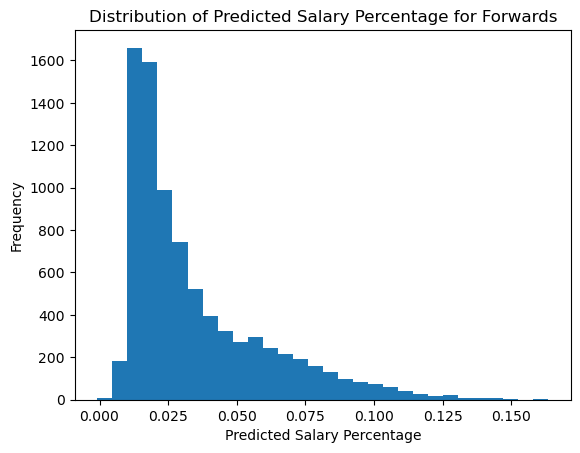

In [67]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(forwards['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Forwards')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Forwards')

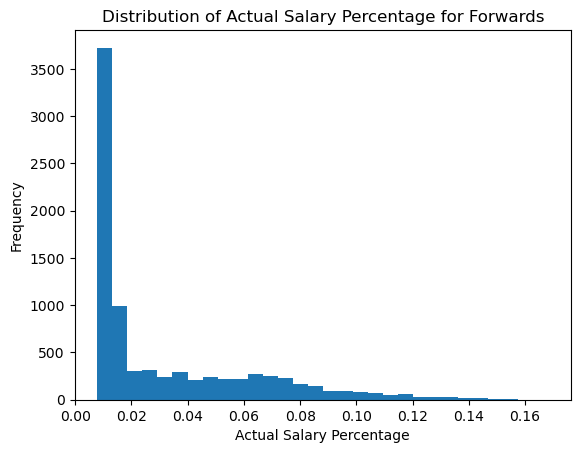

In [74]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(forwards['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Forwards')

In [69]:
# Filter players with over 41 GP
filtered_data = forwards[(forwards['GP'] > 60) & (forwards['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
6233,col,jonathan drouin,2023-24,"$825,000.00","$6,024,877.00","$5,199,877.00",0.072154,5199877.0
4698,nsh,gustav nyquist,2023-24,"$3,185,000.00","$7,089,139.00","$3,904,139.00",0.084900,3904139.0
10619,min,ryan hartman,2023-24,"$1,700,000.00","$5,183,954.00","$3,483,954.00",0.062083,3483954.0
4392,s.j,fabian zetterlund,2023-24,"$1,450,000.00","$4,911,586.00","$3,461,586.00",0.058821,3461586.0
12361,phi,tyson foerster,2023-24,"$863,333.00","$4,088,658.00","$3,225,325.00",0.048966,3225325.0
10745,nsh,ryan o'reilly,2023-24,"$4,500,000.00","$7,411,398.00","$2,911,398.00",0.088759,2911398.0
941,fla,anton lundell,2023-24,"$1,775,000.00","$3,555,329.00","$1,780,329.00",0.042579,1780329.0
12529,nyr,vincent trocheck,2023-24,"$5,625,000.00","$7,261,975.00","$1,636,975.00",0.086970,1636975.0
7908,car,martin necas,2023-24,"$3,000,000.00","$4,559,426.00","$1,559,426.00",0.054604,1559426.0
4082,sea,eeli tolvanen,2023-24,"$1,450,000.00","$2,986,314.00","$1,536,314.00",0.035764,1536314.0


In [70]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
6884,l.a,kevin fiala,2023-24,"$7,875,000.00","$6,914,713.00","$-960,287.00",0.082811,-960287.0
5701,buf,jeff skinner,2023-24,"$9,000,000.00","$8,026,871.00","$-973,129.00",0.096130,-973129.0
6900,stl,kevin hayes,2023-24,"$7,142,857.00","$6,147,713.00","$-995,144.00",0.073625,-995144.0
1650,mtl,brendan gallagher,2023-24,"$6,500,000.00","$5,498,337.00","$-1,001,663.00",0.065848,-1001663.0
12160,ana,troy terry,2023-24,"$7,000,000.00","$5,930,556.00","$-1,069,444.00",0.071025,-1069444.0
10128,l.a,quinton byfield,2023-24,"$3,544,167.00","$2,459,913.00","$-1,084,254.00",0.029460,-1084254.0
4006,buf,dylan cozens,2023-24,"$7,100,000.00","$5,990,132.00","$-1,109,868.00",0.071738,-1109868.0
221,fla,aleksander barkov,2023-24,"$10,000,000.00","$8,812,820.00","$-1,187,180.00",0.105543,-1187180.0
10635,col,ryan johansen,2023-24,"$8,000,000.00","$6,787,080.00","$-1,212,920.00",0.081282,-1212920.0
12723,sea,yanni gourde,2023-24,"$5,166,666.00","$3,947,100.00","$-1,219,566.00",0.047271,-1219566.0


In [71]:
filtered_data[filtered_data['PLAYER'] == 'leon draisaitl'][display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
7312,leon draisaitl,2023-24,"$8,500,000.00","$9,667,783.00","$1,167,783.00",0.115782


In [72]:
predictions = pd.DataFrame(forwards['PRED_SALARY_PERCENTAGE'])

In [73]:
# Save predictions to disk
save_dir = '../../Data/predictions/'
filename = 'forwards_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=True)